In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,BayesianRidge

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Initial data exploration

In [ ]:
data = pd.read_csv('diamonds.csv',index_col=0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [ ]:
data.clarity.unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

In [ ]:
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [ ]:
data.dropna(inplace=True)

# EDA

In [ ]:
def eda_num(col: pd.Series):
  if col.dtype == 'float':
    fig, ax = plt.subplots(1,2,figsize=(14,8))
    sns.kdeplot(data=col, ax=ax[0])
    sns.boxplot(y=col, ax=ax[1])
  else:
    fig, ax = plt.subplots(1,2,figsize=(14,8))
    sns.histplot(data=col, ax=ax[0])
    sns.boxplot(y=col, ax=ax[1])
  plt.show()

## Carat


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


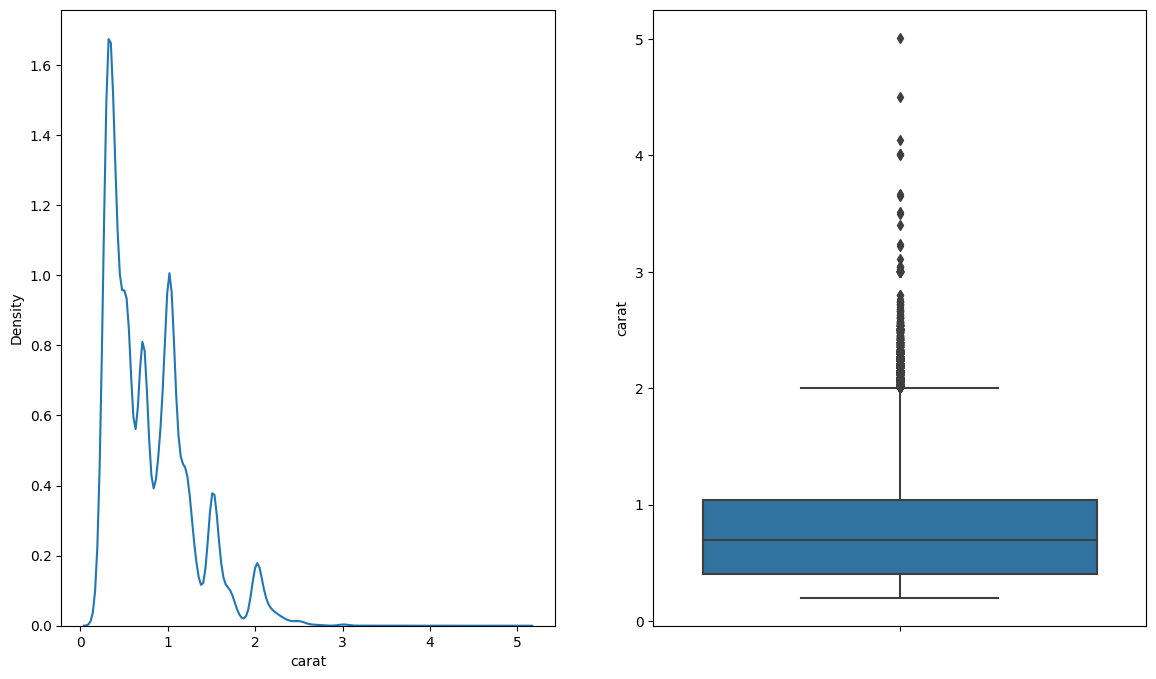

In [ ]:
eda_num(data['carat'])

## Clarity

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


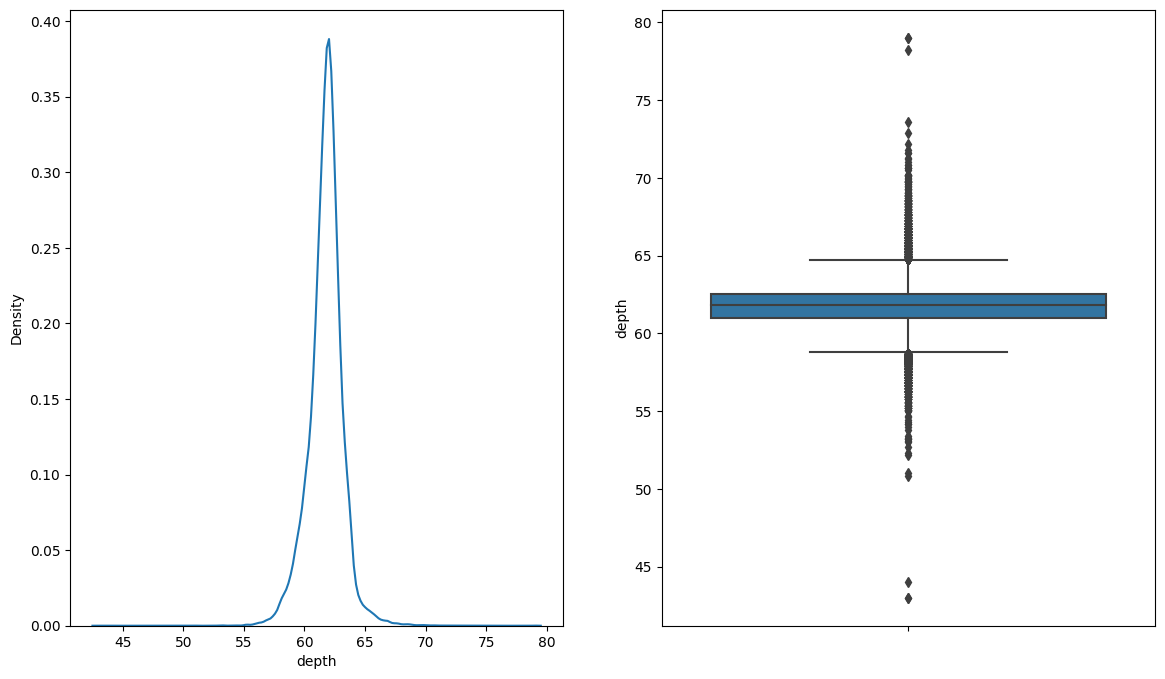

In [ ]:
eda_num(data['depth'])

## Table

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


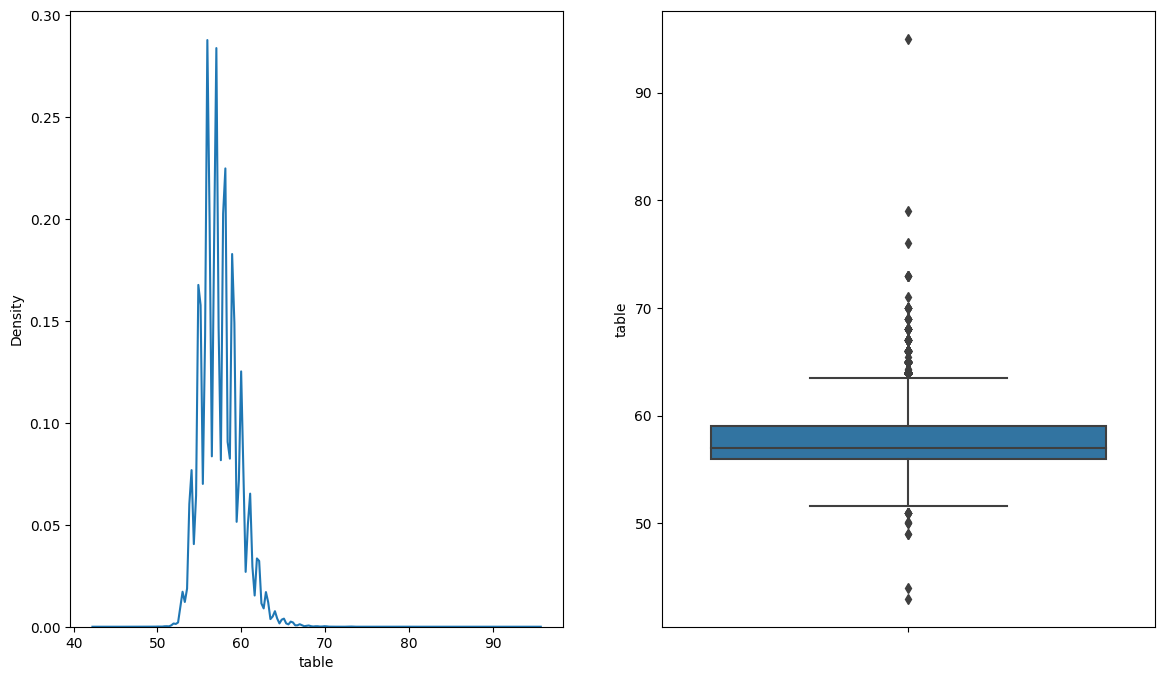

In [ ]:
eda_num(data['table'])

## Price

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


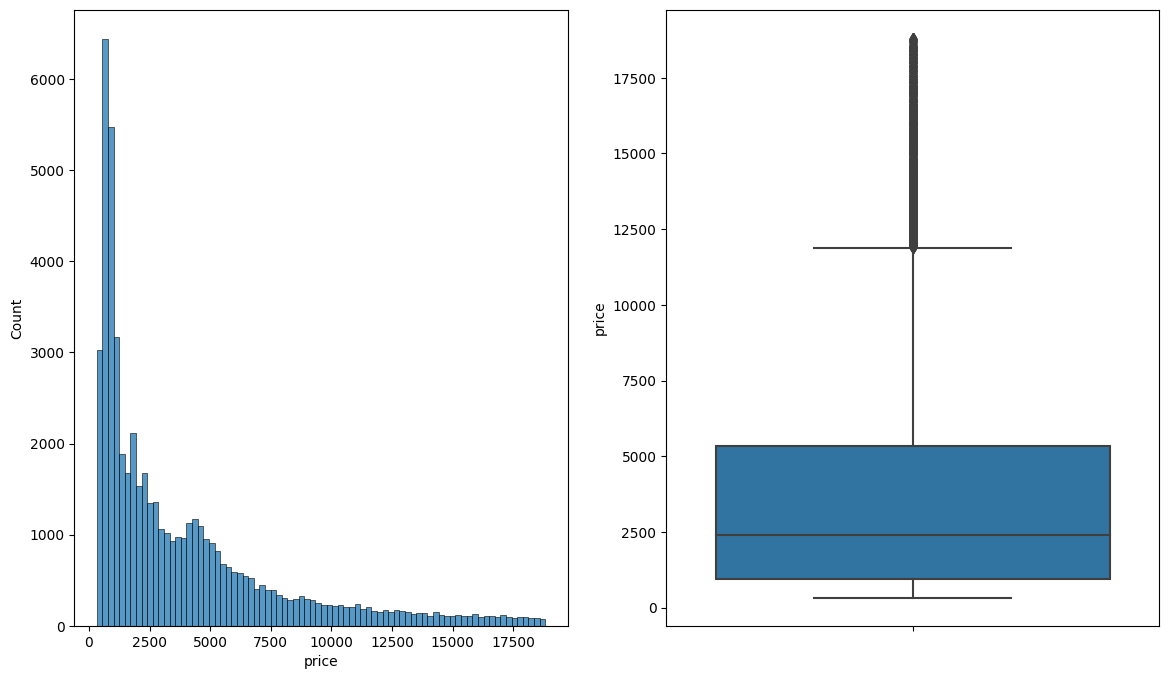

In [ ]:
eda_num(data['price'])

## x

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


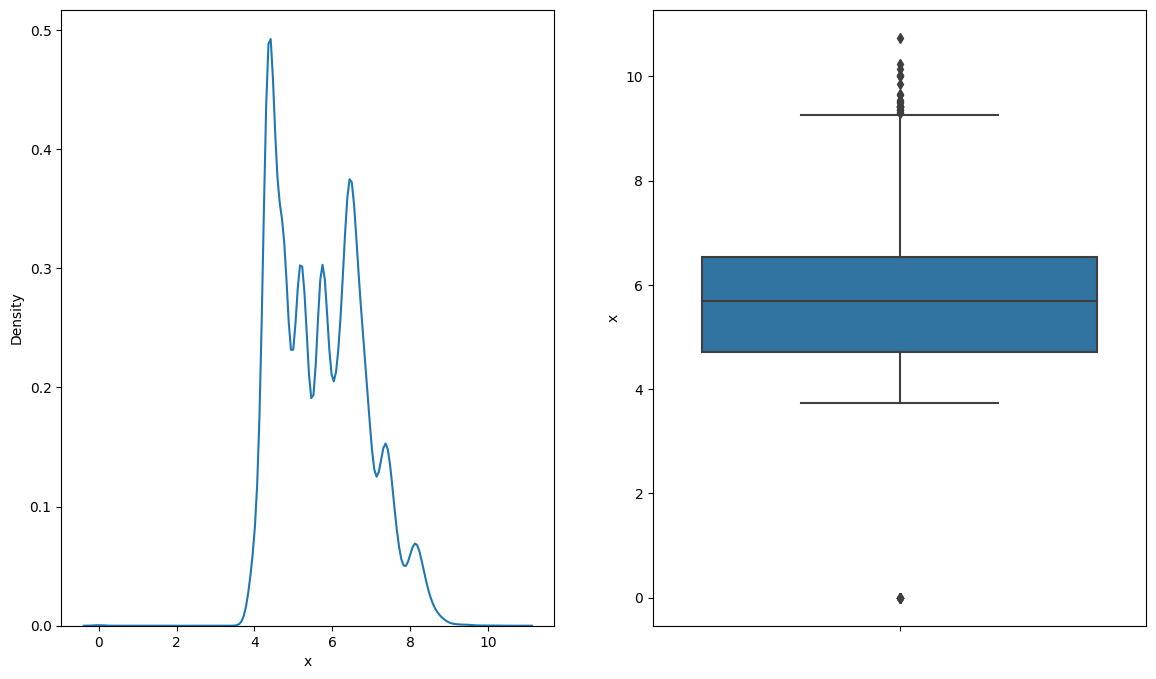

In [ ]:
eda_num(data['x'])

## y

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


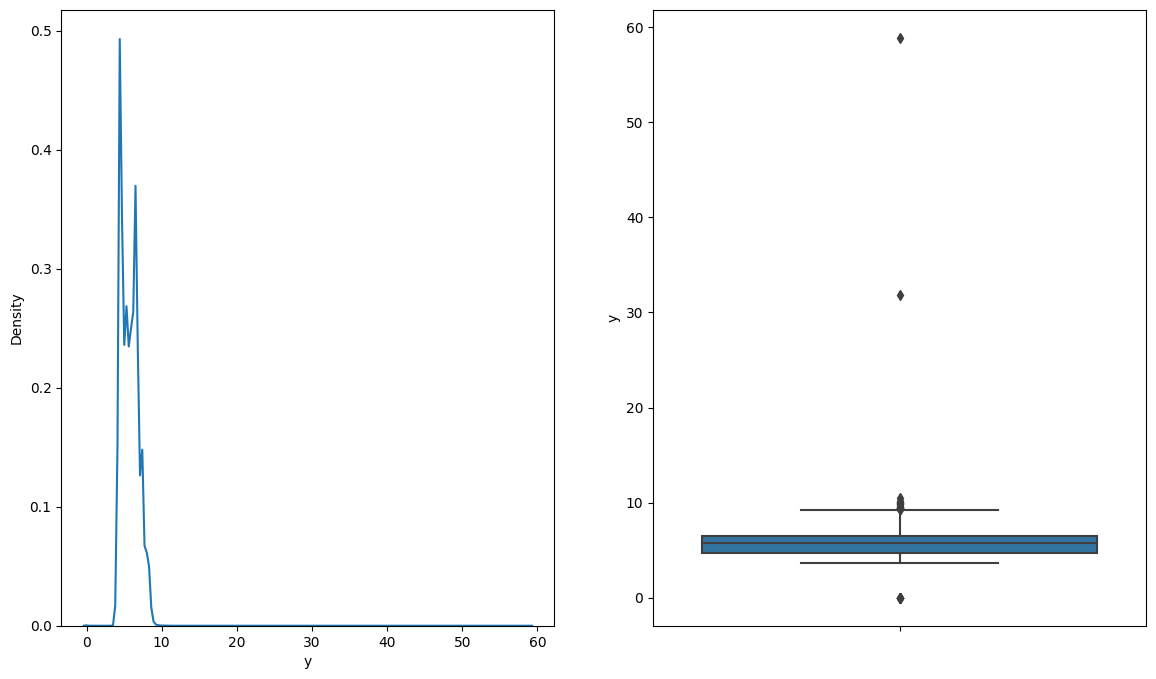

In [ ]:
eda_num(data['y'])

## z

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


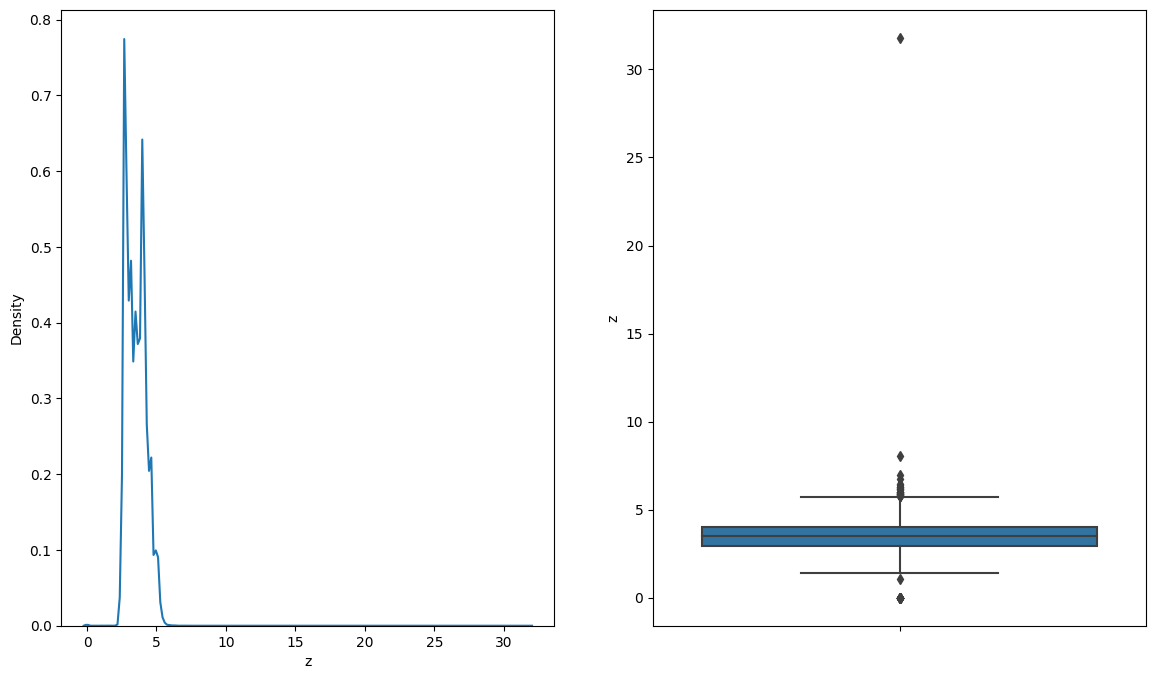

In [ ]:
eda_num(data['z'])

# Remove outliers

In [ ]:
def remove_outlier(data, col_name):
  q1 = data[col_name].quantile(0.25)
  q3 = data[col_name].quantile(0.75)

  iqr = q3-q1
  cond = (data[col_name] <= q3 + 1.5*iqr) & (data[col_name] >= q1 -1.5*iqr)

  data = data[cond]
  return data

In [ ]:
for col in ['x','y','z','depth','carat']:
  data = remove_outlier(data,col)

# Remove target

In [ ]:
price = data.price
data = data.drop(['price'], axis=1)

# Ordinal encoder

In [ ]:
cat_col_names = data.select_dtypes(include=['object']).columns.tolist()
cat_col_names

['cut', 'color', 'clarity']

In [ ]:
num_col_names =  data.select_dtypes(exclude=['object']).columns.tolist()
num_col_names

['carat', 'depth', 'table', 'x', 'y', 'z']

In [ ]:
data = data.reset_index(drop=True)

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder() 
data[cat_col_names] = encoder.fit_transform(data[cat_col_names])

In [ ]:
data

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,2,1,3,61.5,55.0,3.95,3.98,2.43
1,0.29,3,5,5,62.4,58.0,4.20,4.23,2.63
2,0.31,1,6,3,63.3,58.0,4.34,4.35,2.75
3,0.24,4,6,7,62.8,57.0,3.94,3.96,2.48
4,0.24,4,5,6,62.3,57.0,3.95,3.98,2.47
...,...,...,...,...,...,...,...,...,...
40236,0.72,2,0,2,60.8,57.0,5.75,5.76,3.50
40237,0.72,1,0,2,63.1,55.0,5.69,5.75,3.61
40238,0.70,4,0,2,62.8,60.0,5.66,5.68,3.56
40239,0.86,3,4,3,61.0,58.0,6.15,6.12,3.74


carat: np.float32\
depth: np.float32\
table: np.float32\
x: np.float32\
y: np.float32\
z: np.float32\
color: ['E', 'I', 'J', 'H', 'F', 'G', 'D']
cut: ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
clarity: ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']

# Split data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, price,test_size=0.2, random_state=1)

# Standardize numerical values

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)


In [ ]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)


# Modeling

In [ ]:
model = XGBRegressor()
model.fit(X_train_scaled_df, y_train)
pred = model.predict(X_test_scaled_df)

MSE 1: 173004.7937139462
R2 1: 0.983822942415229
MAE 1: 216.2328946055174


In [ ]:
metrics = pd.DataFrame(index=['Train', 'Test'], columns=['MSE', 'R2_score', 'MAE'])
train_pred = model.predict(X_train_scaled)
test_pred = model.predict(X_test_scaled)

metrics.loc['Train', 'MSE'] = mean_squared_error(y_train, train_pred)
metrics.loc['Train', 'R2_score'] = r2_score(y_train, train_pred)
metrics.loc['Train', 'MAE'] = mean_absolute_error(y_train, train_pred)

metrics.loc['Test', 'MSE'] = mean_squared_error(y_test, test_pred)
metrics.loc['Test', 'R2_score'] = r2_score(y_test, test_pred)
metrics.loc['Test', 'MAE'] = mean_absolute_error(y_test, test_pred)

In [ ]:
metrics.T

,Train,Test
MSE,79724.207993,173004.793714
R2_score,0.992554,0.983823
MAE,167.007572,216.232895


<ipython-input-218-4ca60e6e90dc>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  metrics[['MSE','R2_score','MAE']].plot(kind='bar', ax=ax,subplots=True, rot=0)


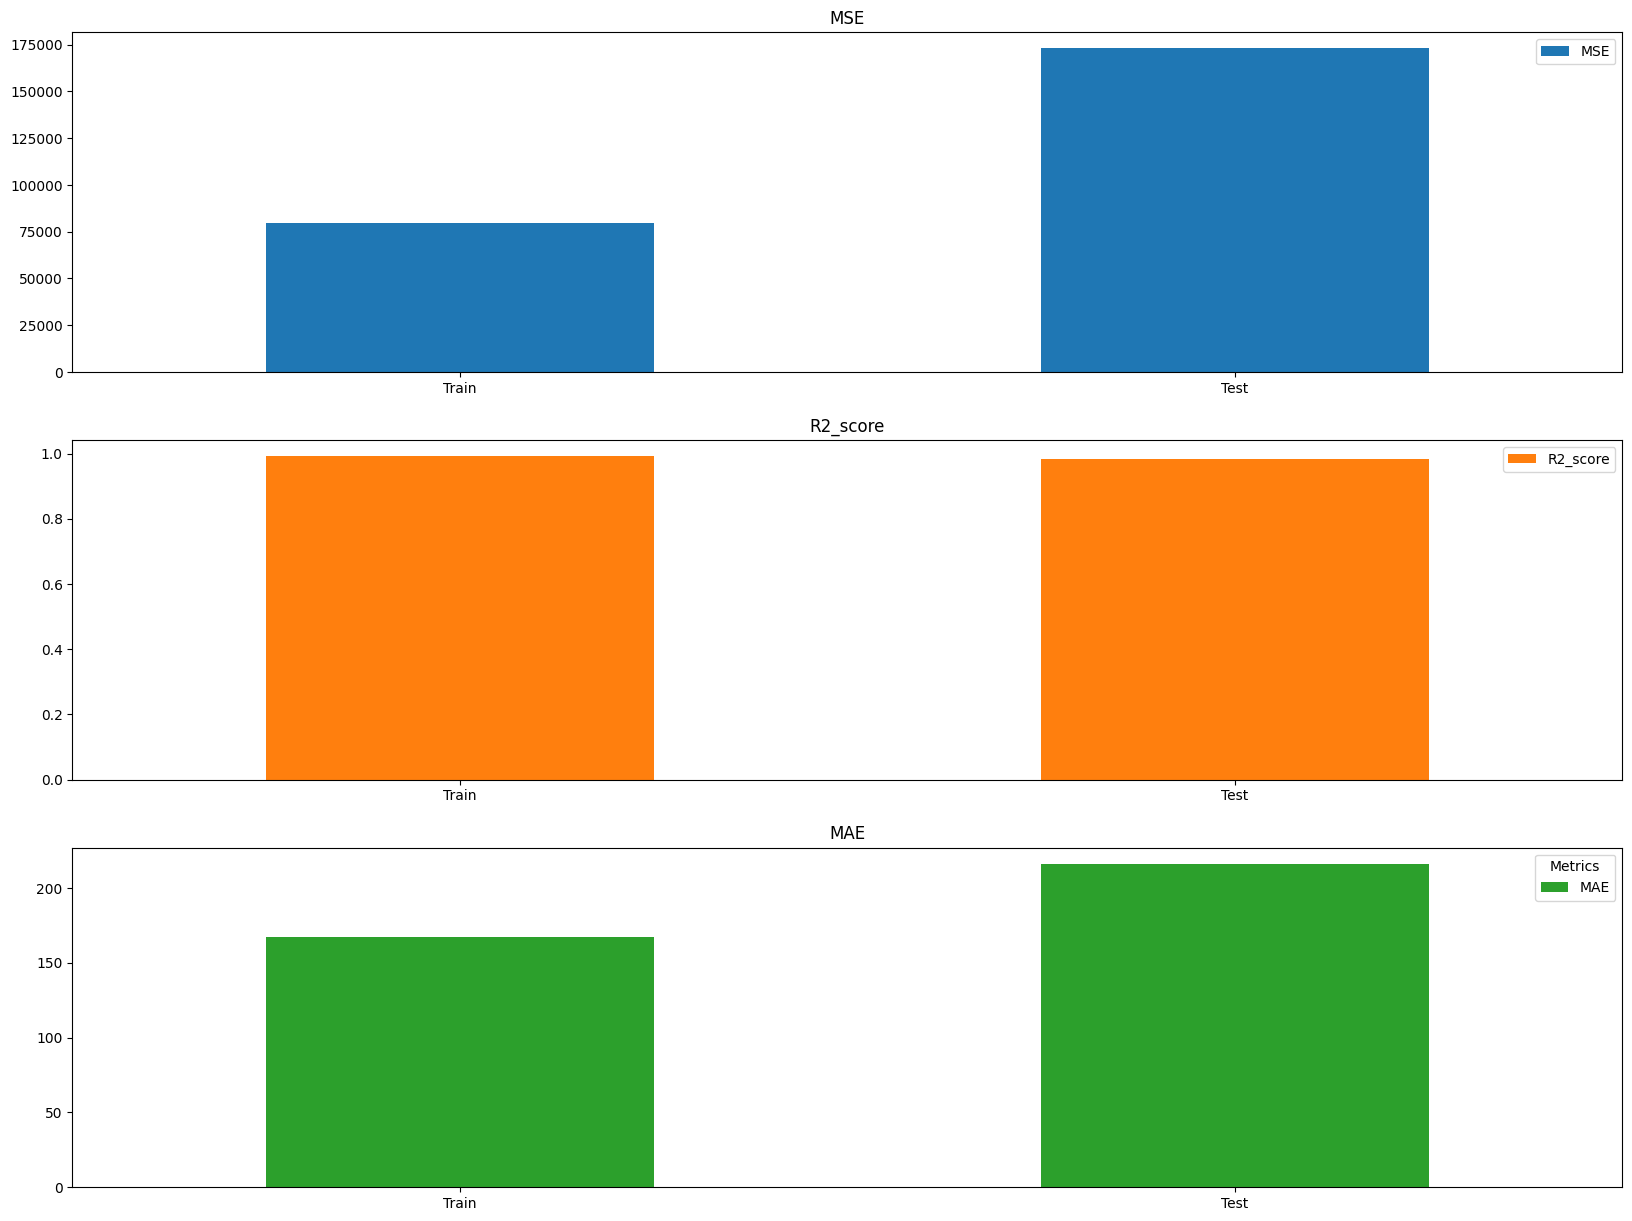

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
metrics[['MSE','R2_score','MAE']].plot(kind='bar', ax=ax,subplots=True, rot=0)
ax.set_ylabel('Values')
ax.set_title('Comparison of Train and Test Metrics')

plt.legend(title='Metrics')
plt.show()